# **Project Overview**
The objective of this project is to use a Deep Learning model to detect and classify cyclists, pedestrians, and vehicles in urban environments using video clips. For the purpose of our project, we implemented the YOLOv5 algorithm using PyTorch framework. This version of the YOLO model was chosen because it is convienently usable within the ultralytics framework which streamlines the implementation process. The YOLO model family is also state of the art for object detection in videos and images. The original weights are trained on the COCO data set. The model is trained again on a selected subsample of the COCO dataset, with selected 8 classes representing traffic environment. 

The primary goal is to develop a strong understanding of how to use Deep Learning models to detect road traffic, an practice deep learning object detection methods.

**Set Up**

To begin with, we installed the required dependencies for our project, including PyTorch, OpenCV, NumPy, and other essential packages. We then obtained the YOLOv5 model from the ultralytics repository on GitHub and installed all dependencies required to run it. The installation was done using the following commands. This allowed us to initialize the YOLOv5 model and load it with the selected dataset for training and testing.

In [1]:
import os.path
import torch
import torch
import cv2 as cv
import json
import time
import numpy as np


c:\Users\Wolf\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#getting yolo model from ultralytics and installing all dependecies
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install
import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.5/78.2 GB disk)


# ***Dataset***
**Dataset Analysis**

For our project, we used a subsample of the COCO dataset containing images of various urban environments. The subsample was chosen to include images containing people, cars, stop signs, buses, trucks, traffic signs, bicycles, and motorcycles. We used this subsample to train our YOLOv5 model to detect and classify these objects in real-time videos. 

The COCO dataset is a widely used dataset for object detection tasks, and it contains over 330,000 images with over 2.5 million object instances labeled with 80 different categories. The subset we chose for our project consists of approximately 1,000 images labeled with the aforementioned 8 categories. We analyzed the dataset to gain a better understanding of its characteristics. The dataset contains images of varying resolutions and aspect ratios, and the objects of interest appear in different scales and orientations. The data augmentation is done automatically by the ultralytics framework.

The 8 categories are roughly evenly represented in the data set to avoid bias.

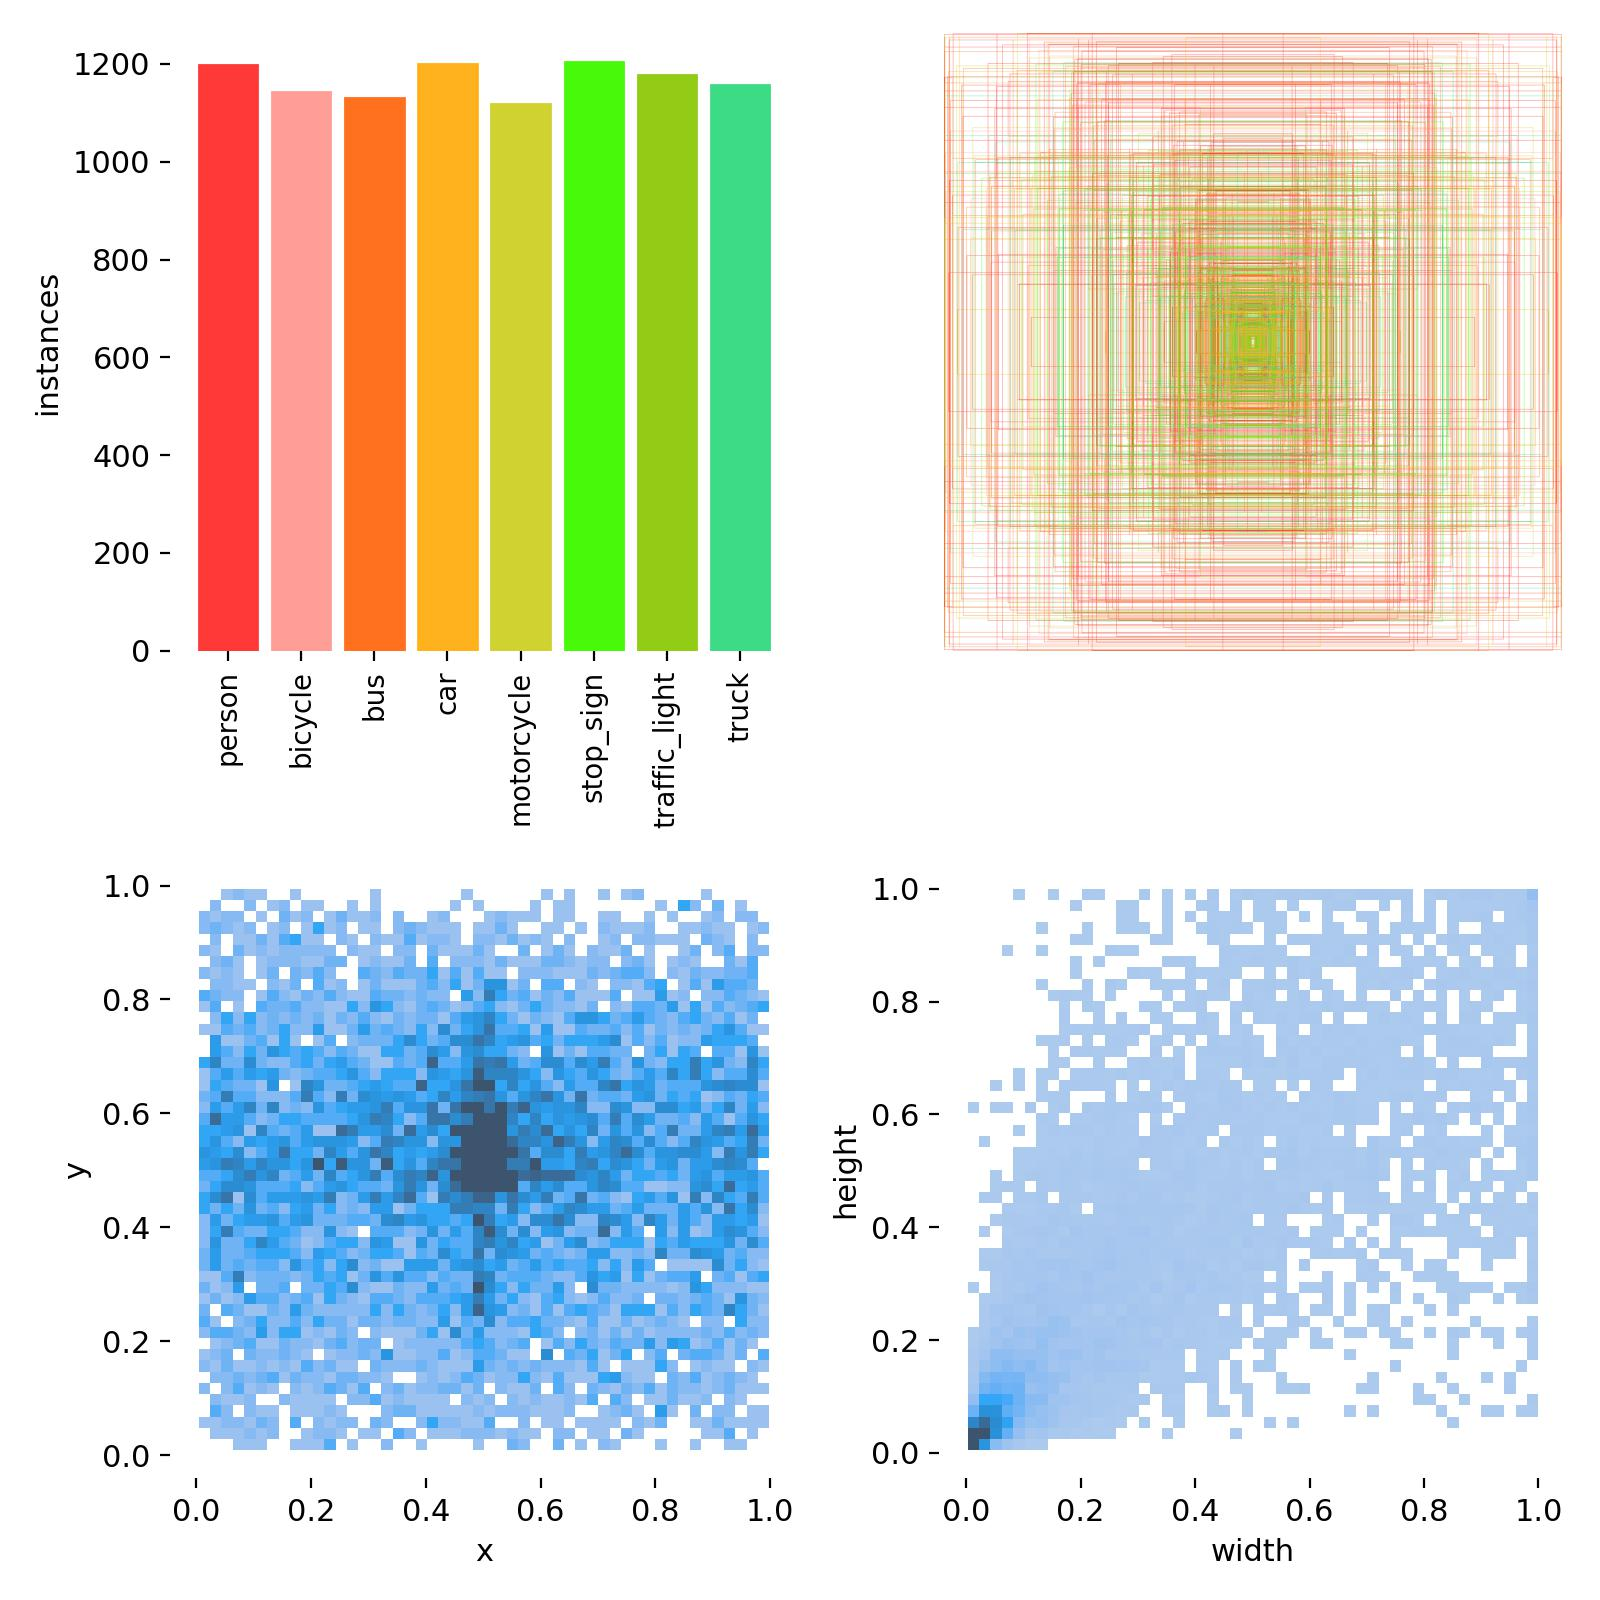

In [15]:
display.Image("..\model_training\labels.jpg")

**Dataset Preparation**

We split our dataset into training, validation, and testing sets, with 80%, 10%, and 10% of the data in each set, respectively. We used the training set to train the model, the validation set to tune the hyperparameters and prevent overfitting, and the testing set to evaluate the final performance of the model.

In [ ]:
#dataset is the subset of coco dataset for 8 classes : people, car, stop sign, bus, truck, traffic sign, bicycle, motorcycle

**Reference** 

Before training we take a look at the performance of the YOLOv5 model on our dataset. And will also do a validation run on the initial coco dataset on which the model is already trained. Below is an example of the detection in our own data set before training.

In [ ]:
!python detect.py --source D:\Universitaet_Linz\SoSe23\InteoAuto\Exsercises\Ex01_Repo\datasets\dataset\dataset\images\test --weights yolov5s6.pt --project runs_traffic --name feature_extraction

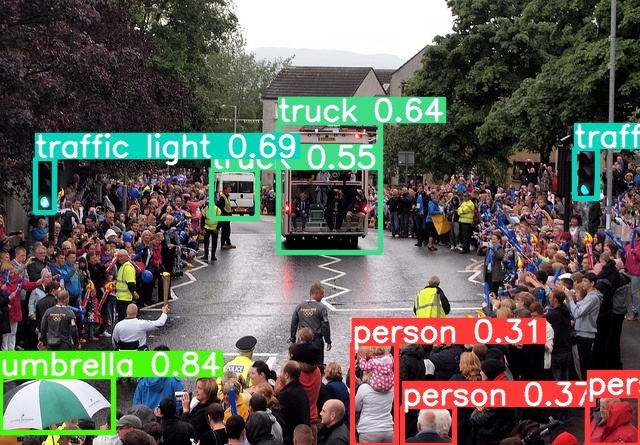

In [41]:
display.Image(f"D:\\Universitaet_Linz\SoSe23\InteoAuto\Exsercises\Ex01_Repo\yolov5\\runs_traffic\\feature_extraction4\\000000463151.jpg")

In [37]:
!python val.py --data coco.yaml --weights yolov5s6.pt --project runs_traffic --name feature_extraction

^C


**mAP Before Training**

We can see the mAP of the model on the original coco data set below. The model was originally trained on 80 classes and the precision recall trade off varies because not all classes are evenly represented in the original data set.

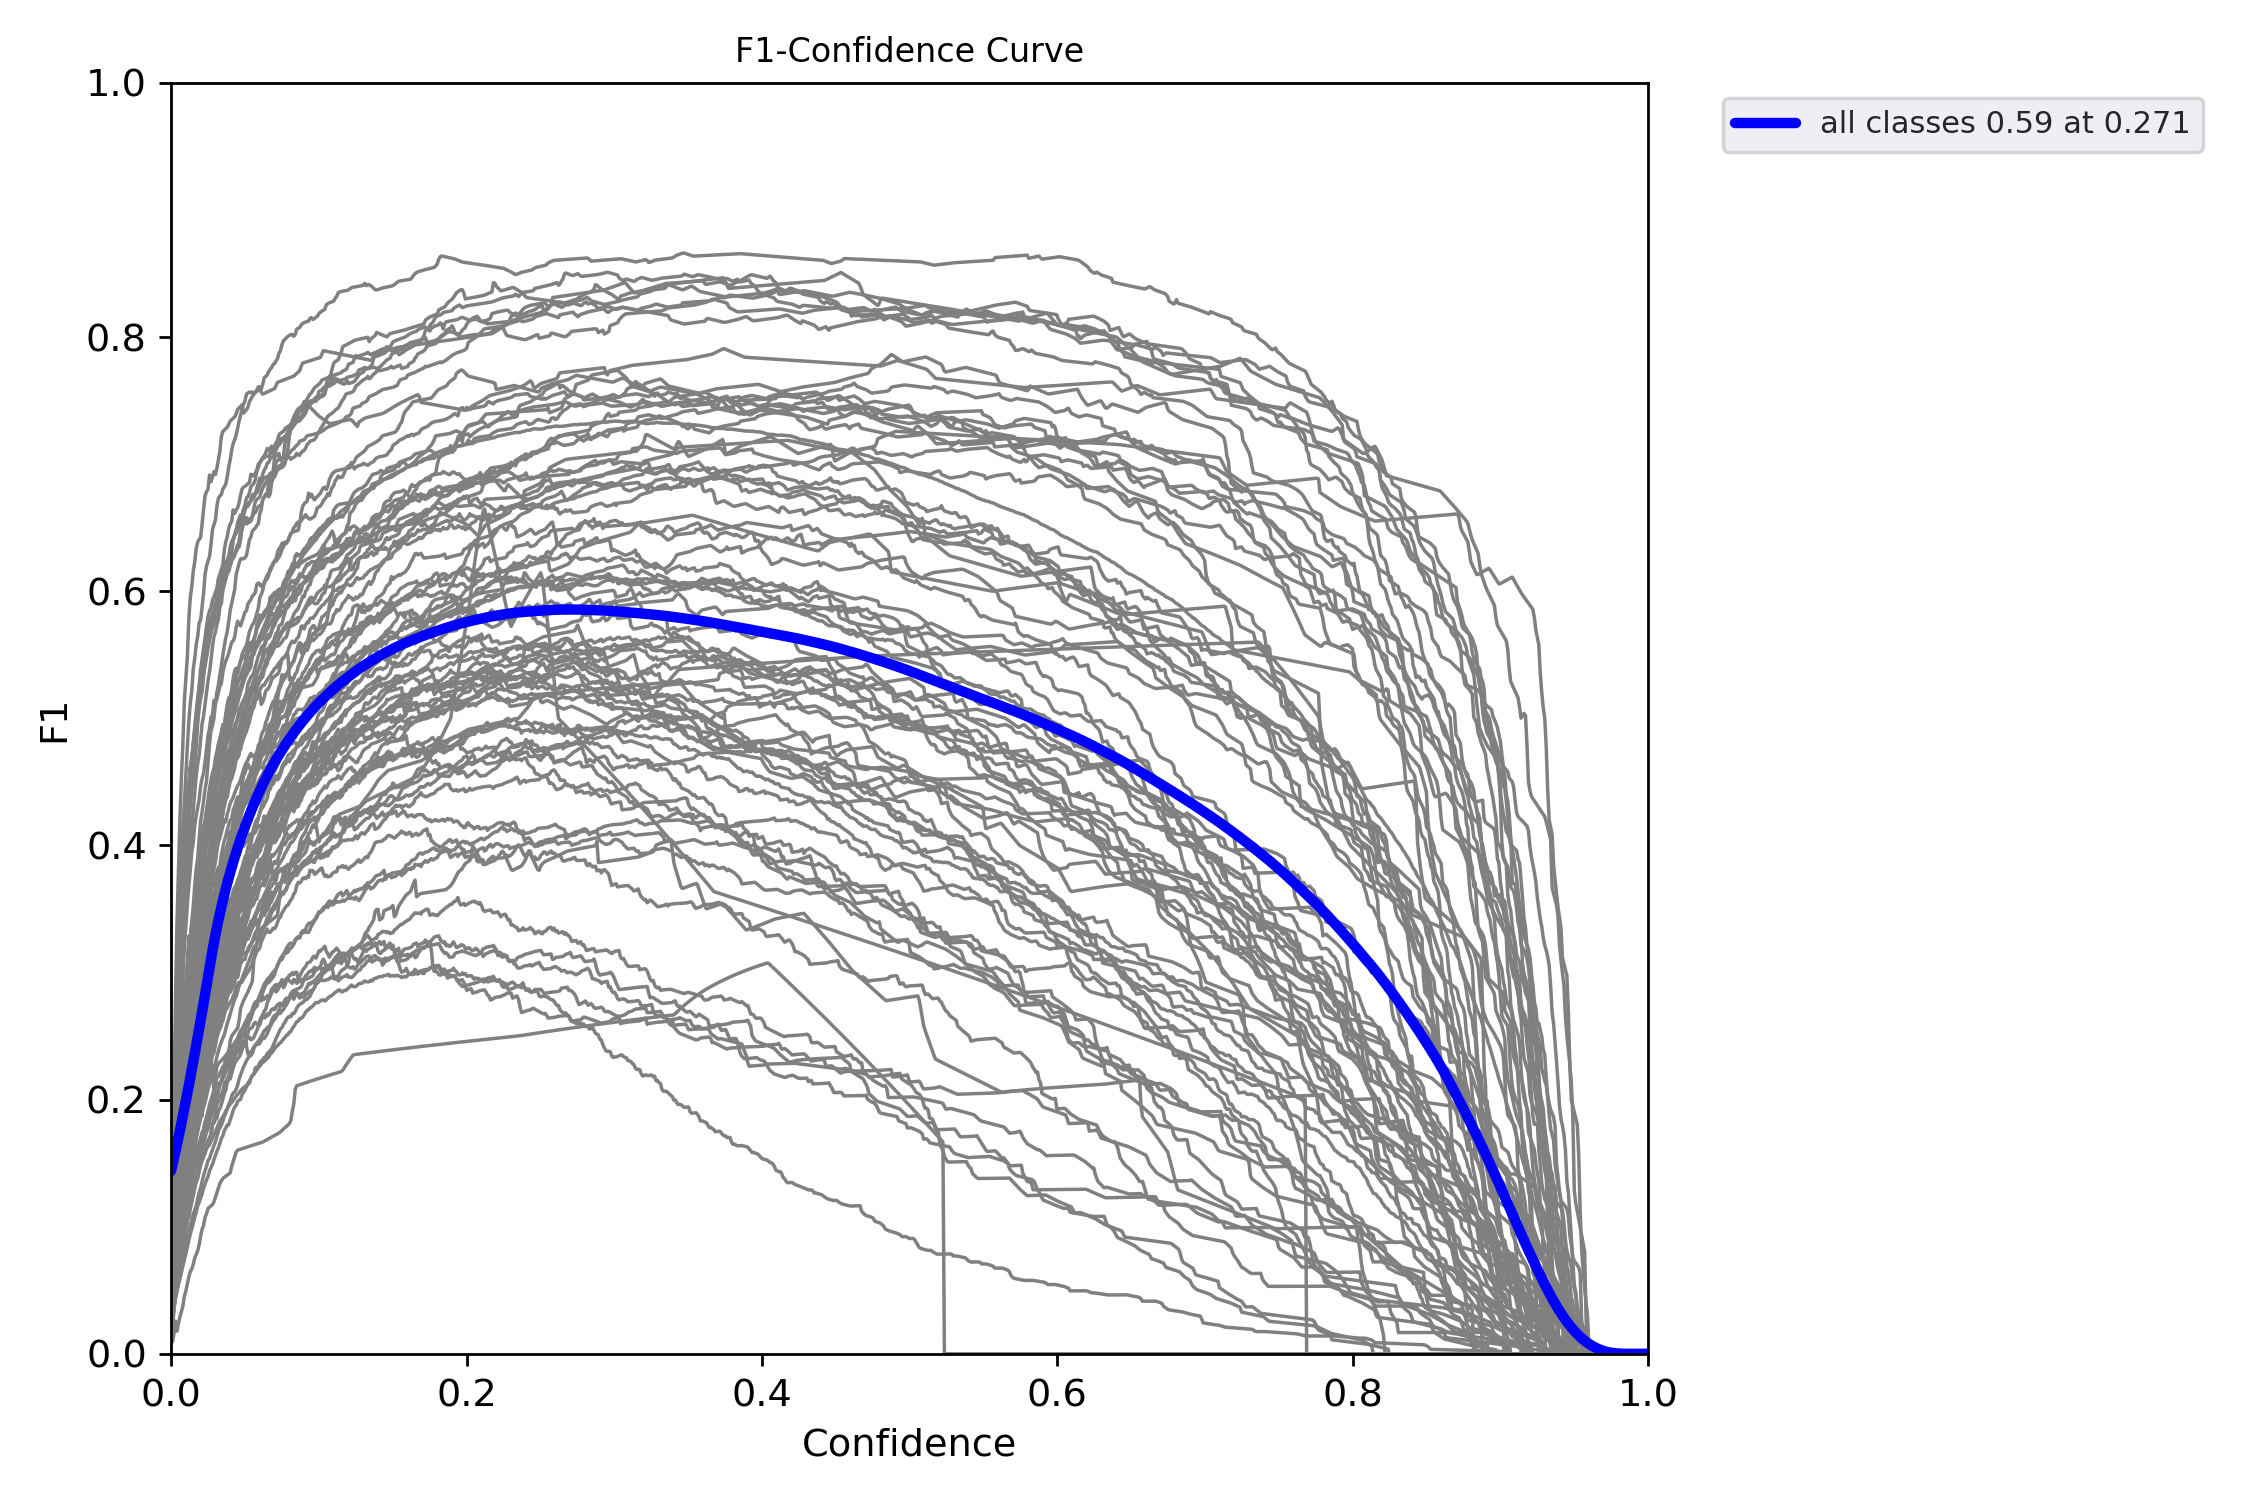

In [44]:
display.Image(f"D:\\Universitaet_Linz\SoSe23\InteoAuto\Exsercises\Ex01_Repo\model_pre_training\F1_curve.png")

**Training**

To train our YOLOv5 model, we started by freezing the convolutional layers and training only the linear layers. We did this by running the following command in the terminal.

This command starts the training script and specifies the following parameters: --batch 32: Sets the batch size to 32 images per iteration. 
--epochs 7: Specifies the number of training epochs to run. 
--data '/content/dataset/data.yaml': Points to our dataset configuration file, which contains information about the training and validation sets, as well as the class labels. 
--weights 'yolov5s6.pt': Specifies the initial weights for our model. We used the pre-trained yolov5s6.pt weights, which are trained on the COCO dataset. --project 'runs_traffic': Specifies the name of the project, which is used to organize the training logs and results. 
--name 'feature_extraction': Specifies the name of the training run, which is used to differentiate between different experiments. 
--freeze 12: Freezes the first 12 layers of the model, which correspond to the convolutional layers. This means that only the last few layers will be trained during the training process. 

During training, the script outputs a variety of information, including the current epoch, the number of iterations, the loss values, and the training and validation metrics. We used this information to monitor the training process and adjust the hyperparameters as needed. The model was trained during 7 epochs. A low epoch count was chosen to avoid overfitting, because the YOLO model is already trained on comparable images.

In [2]:
#freeze the convolutional layers and train only the linear layers 
!python train.py --batch 32 --epochs 7 --data '/content/dataset/data.yaml' --weights 'yolov5s6.pt' --project 'runs_traffic' --name 'feature_extraction'  --freeze 12


python3: can't open file '/content/train.py': [Errno 2] No such file or directory


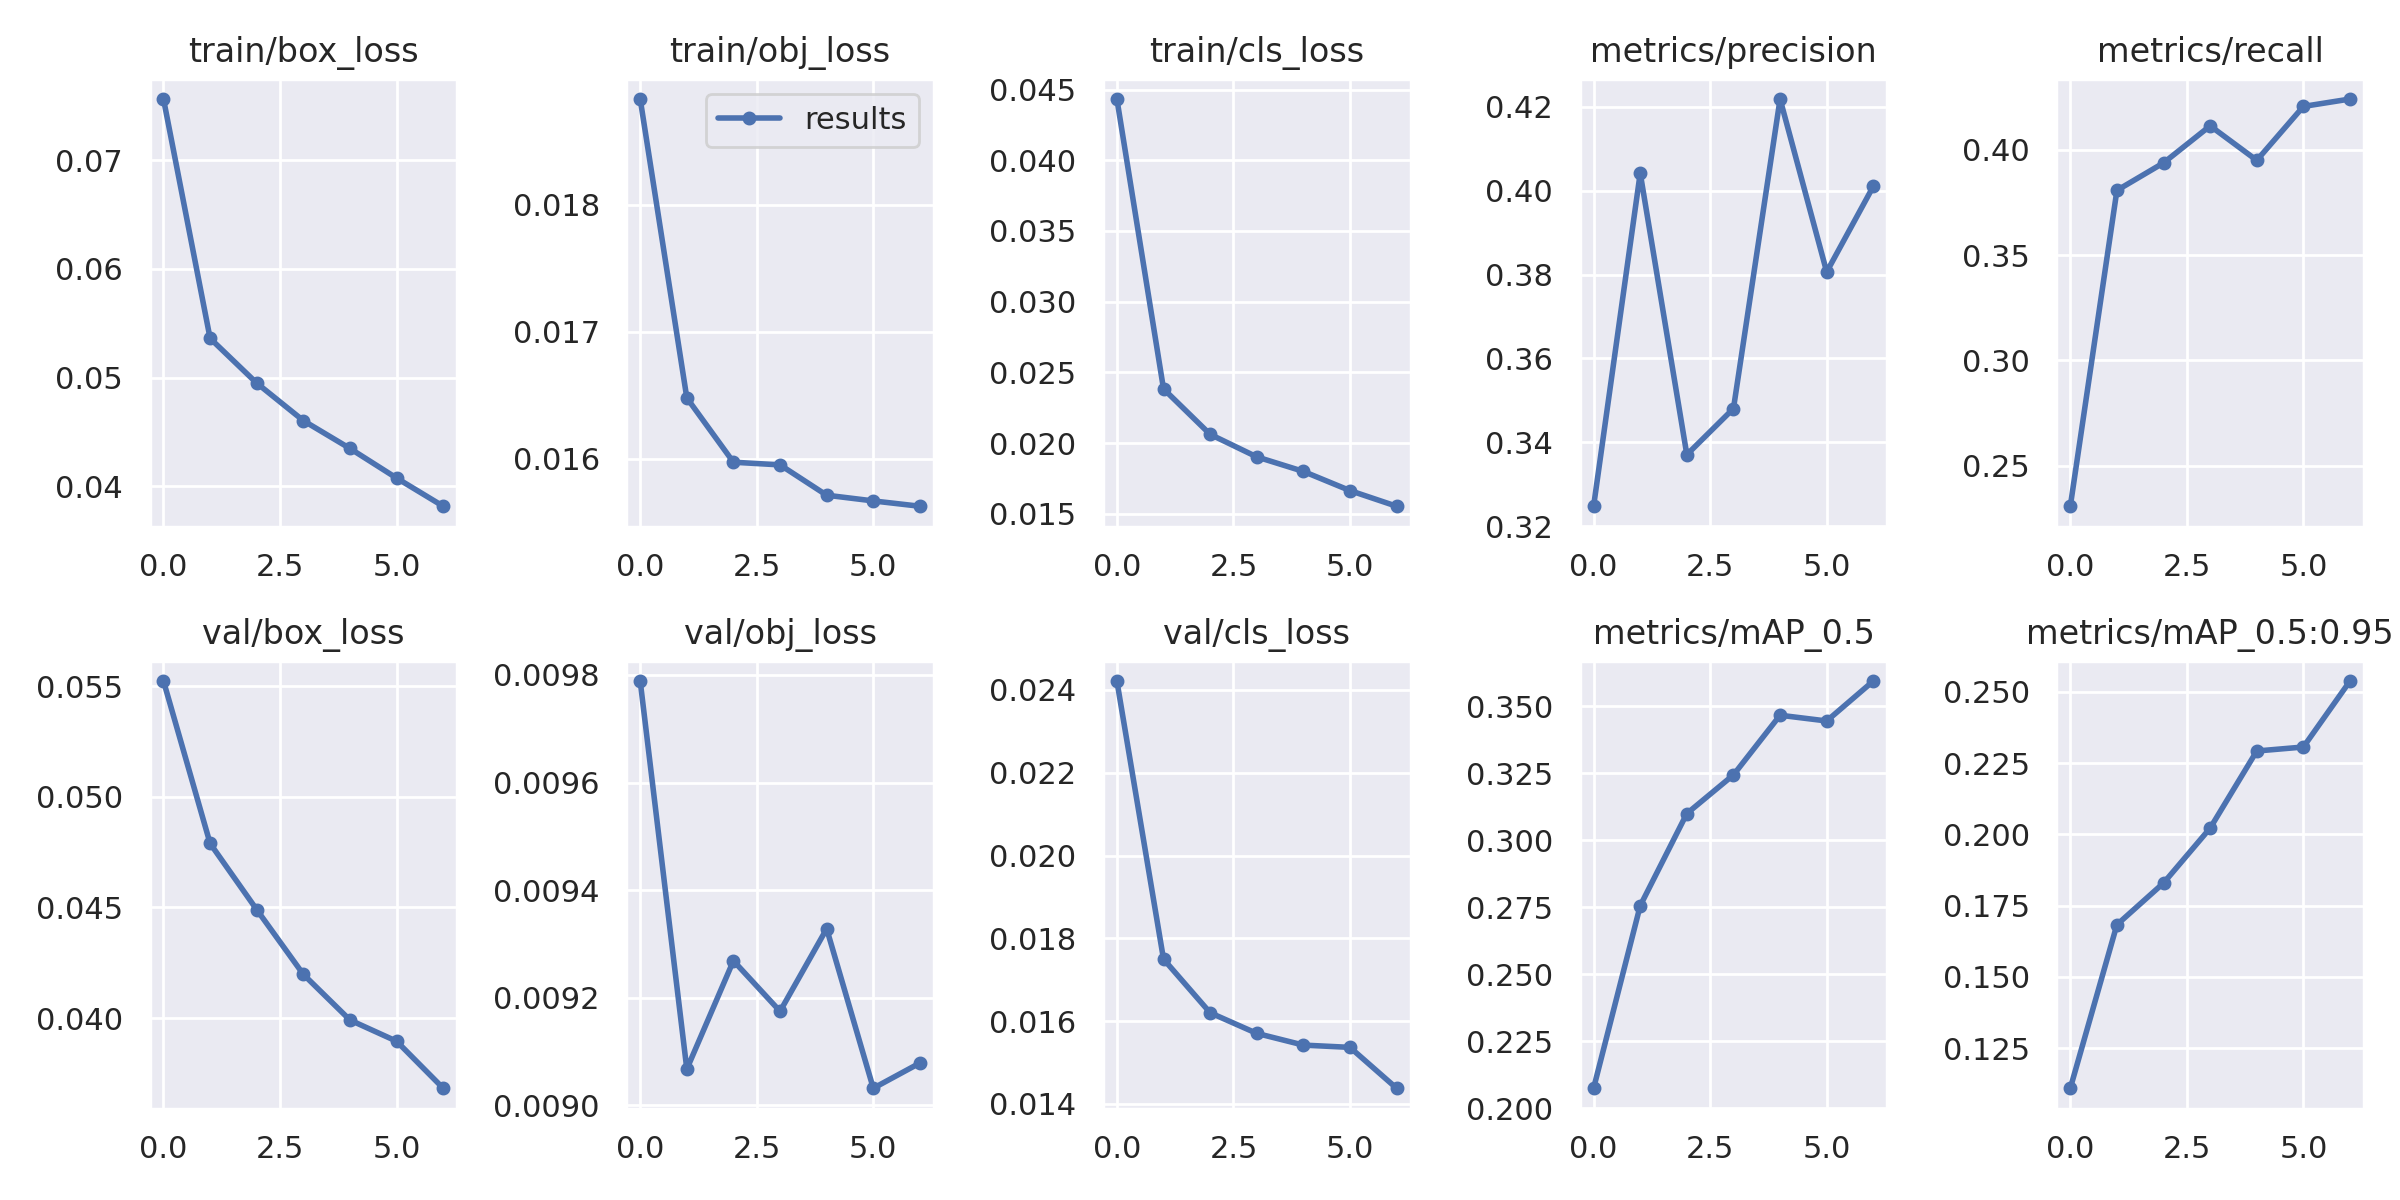

In [ ]:
#training ouput
display.Image(f"runs_traffic/feature_extraction4/results.png")

**Training Results**

As visibile in the F1 curve, precision and recall was high for the stop sign category, but all other classes have imbalances and show precision recall trade offs. The imbalance is particulary high in the car category.

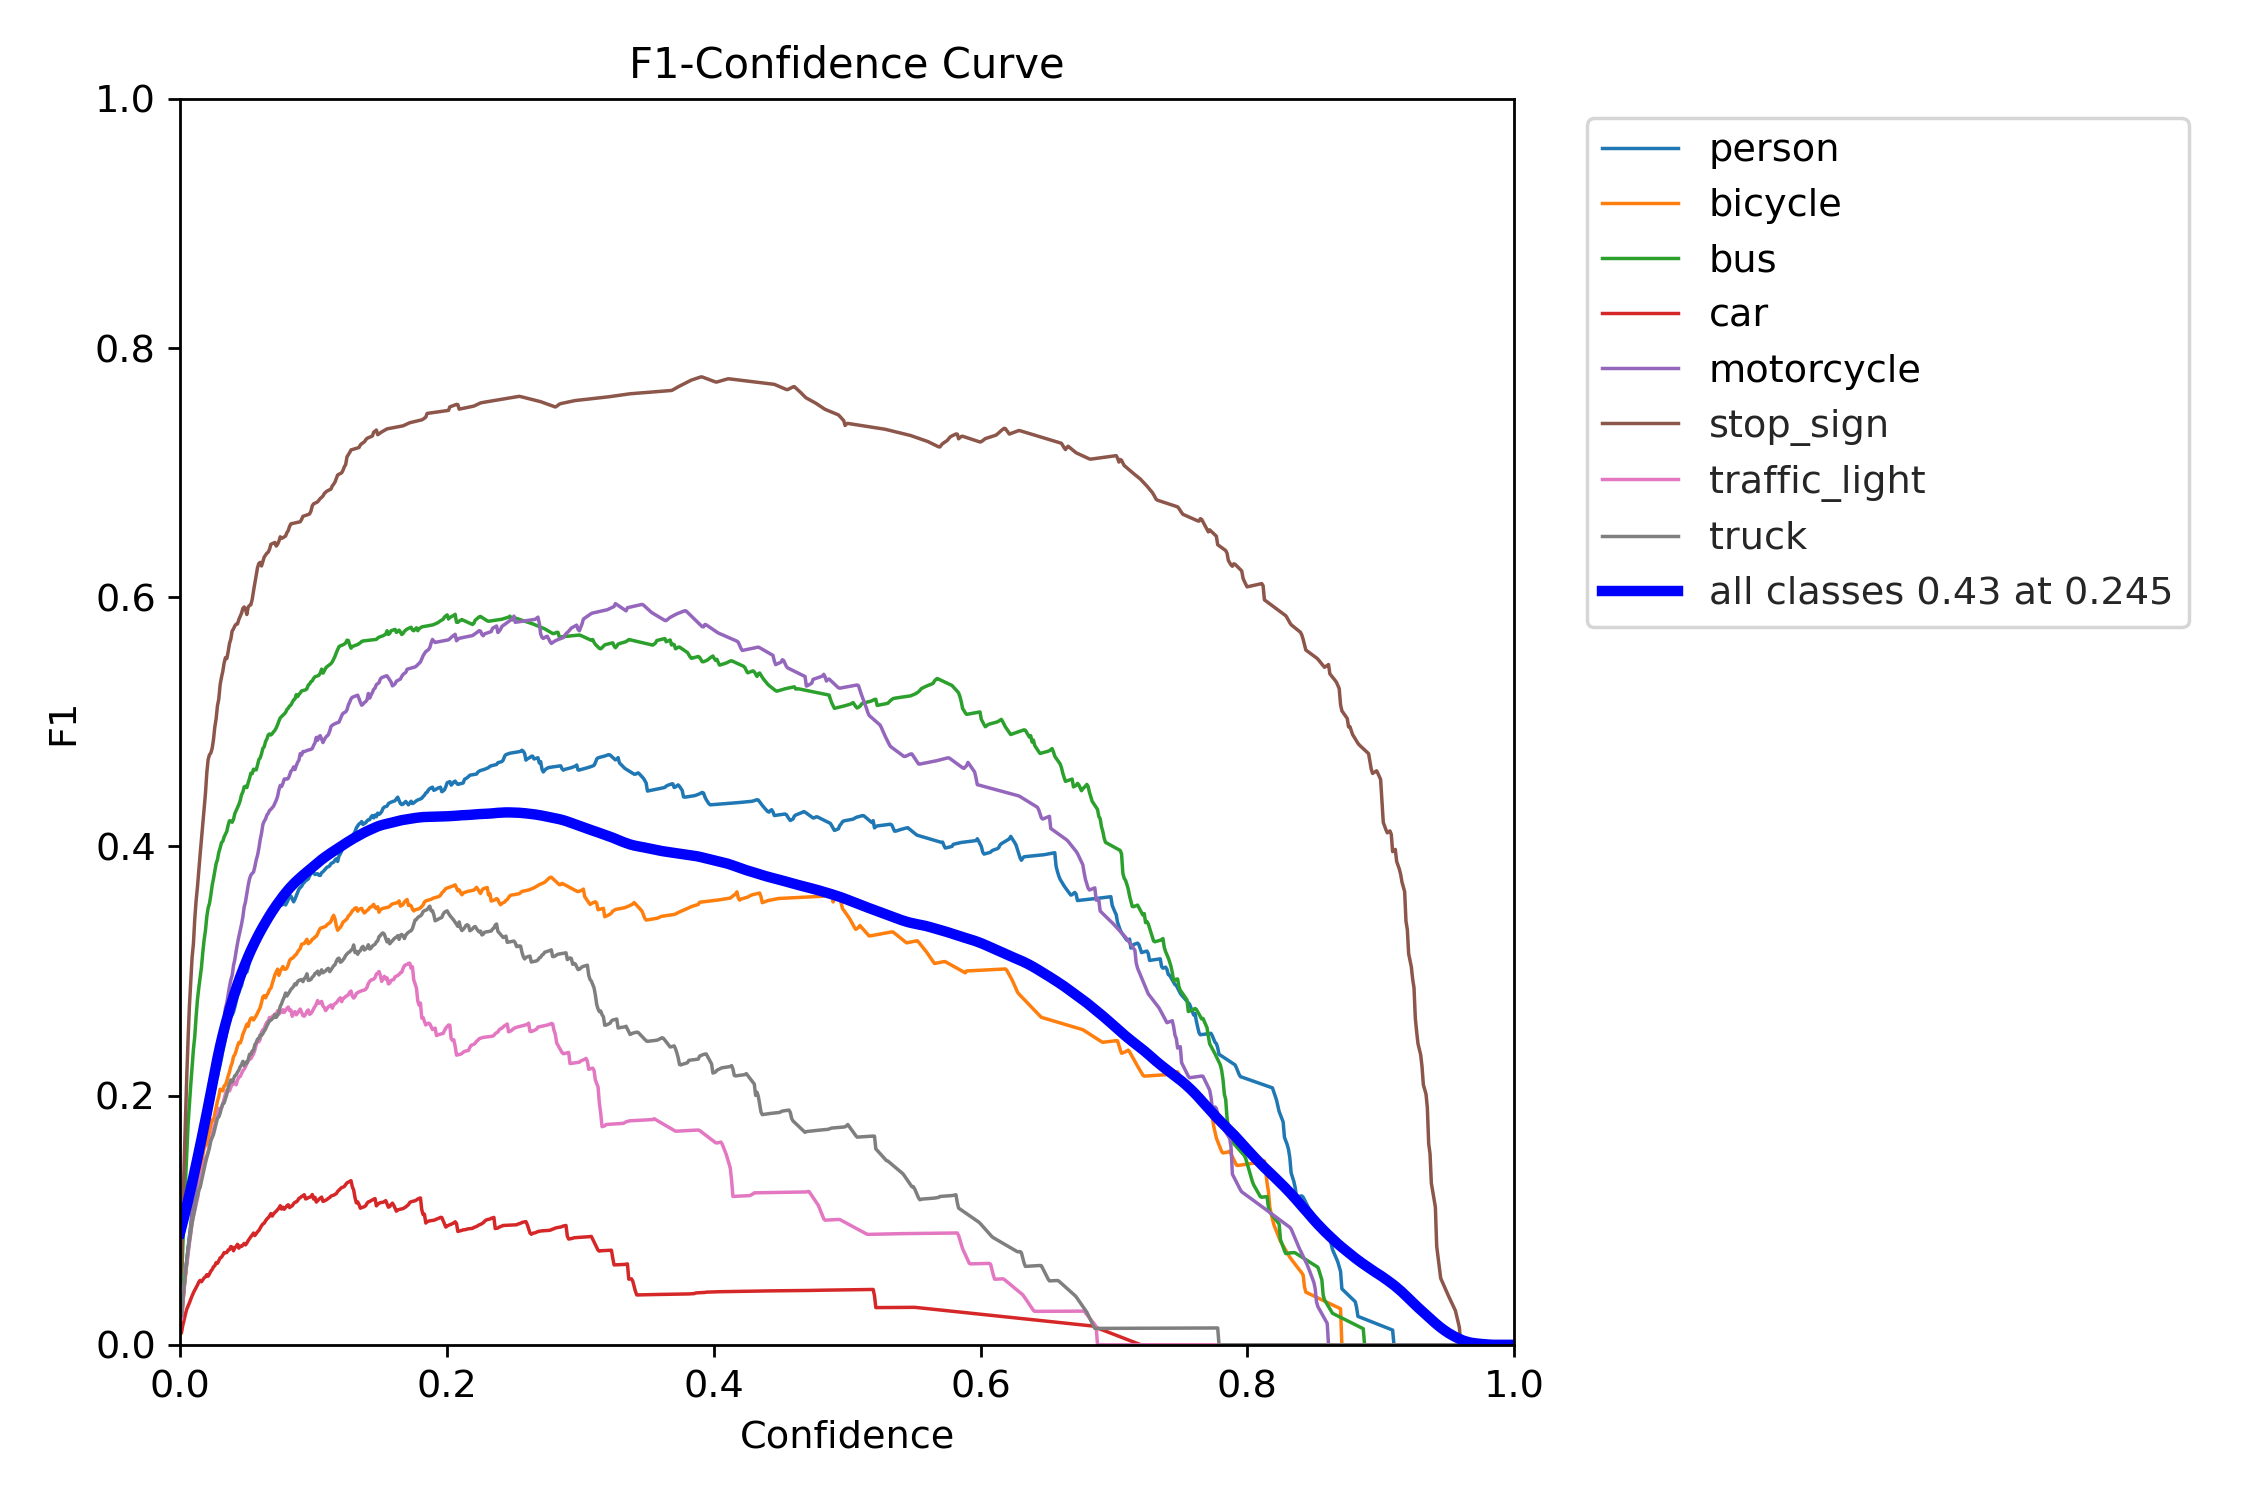

In [19]:
display.Image("..\model_training\F1_curve.png")

**Precision - Recall**

We can see in our PR curve, that the recall for cars is high but the precision is low, which means that our model identifies most cars correctly but tends to produce false positives too. As indicated in the F1 curve, the stop sign category shows the best precision recall trade off. All other classes show worse performance. Although some classes are detected efficiently, the mean area precision at the threshold of 0.5 results in only 0.382 for all 8 classes.

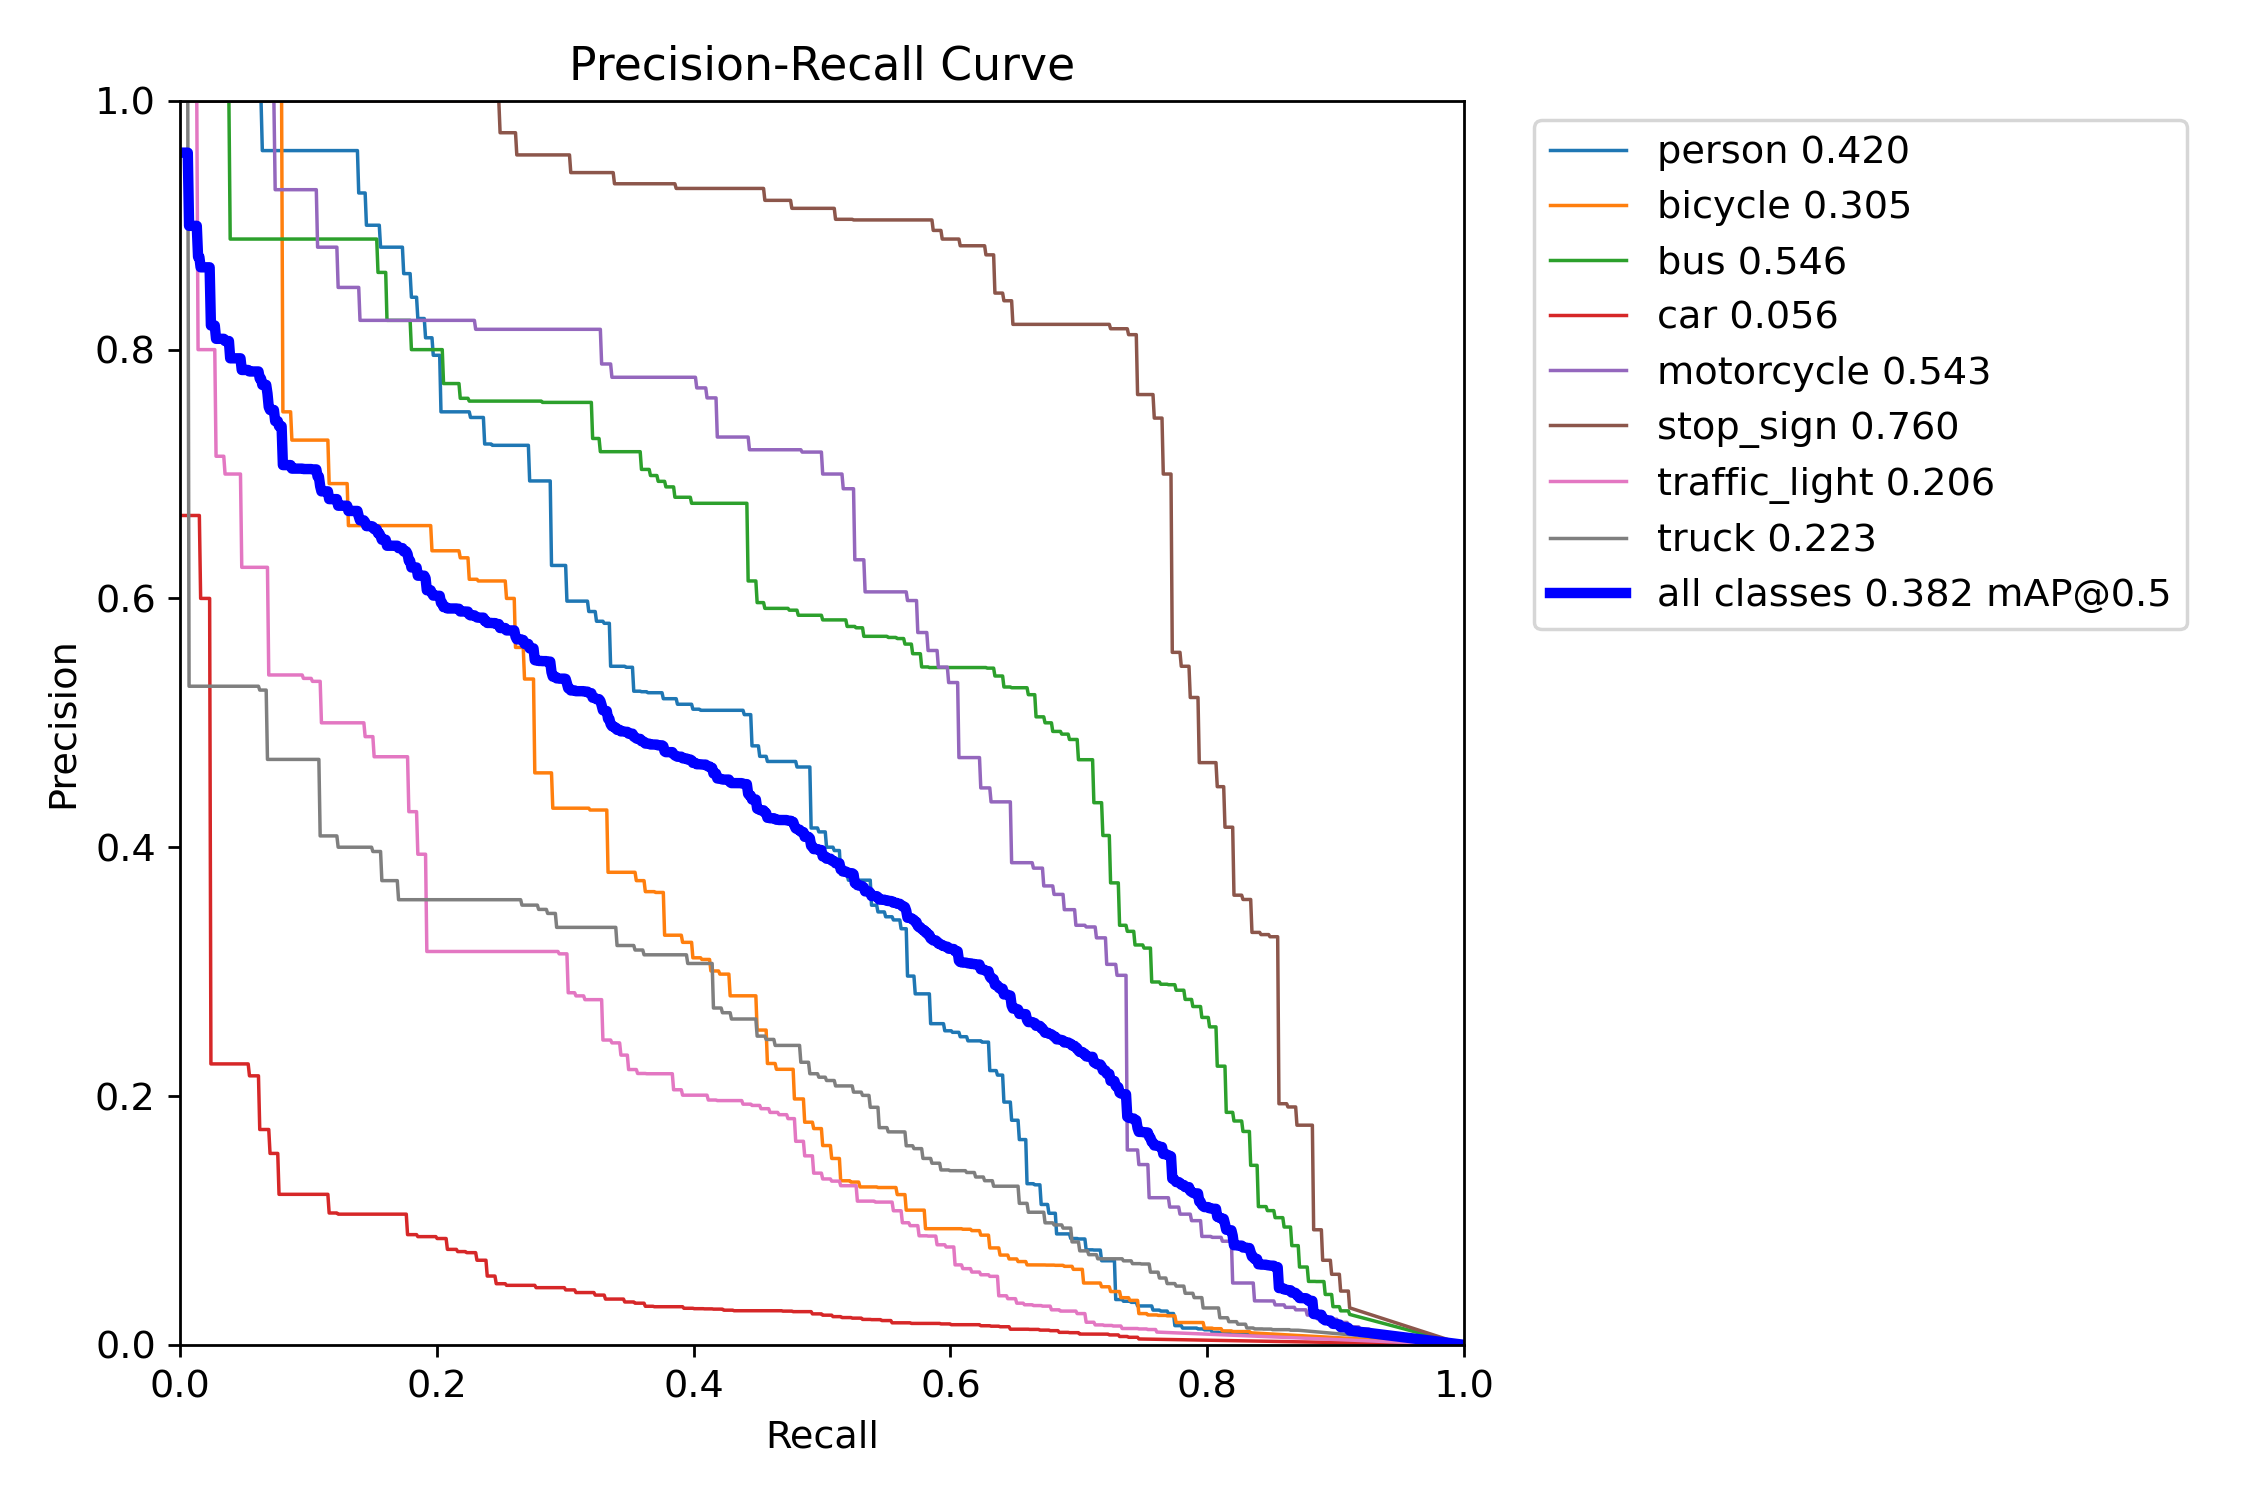

In [21]:
display.Image("..\model_training\PR_curve.png")

** Result Sample**

When looking at some samples after validating, the results are promising even if the mAP seems rather low.

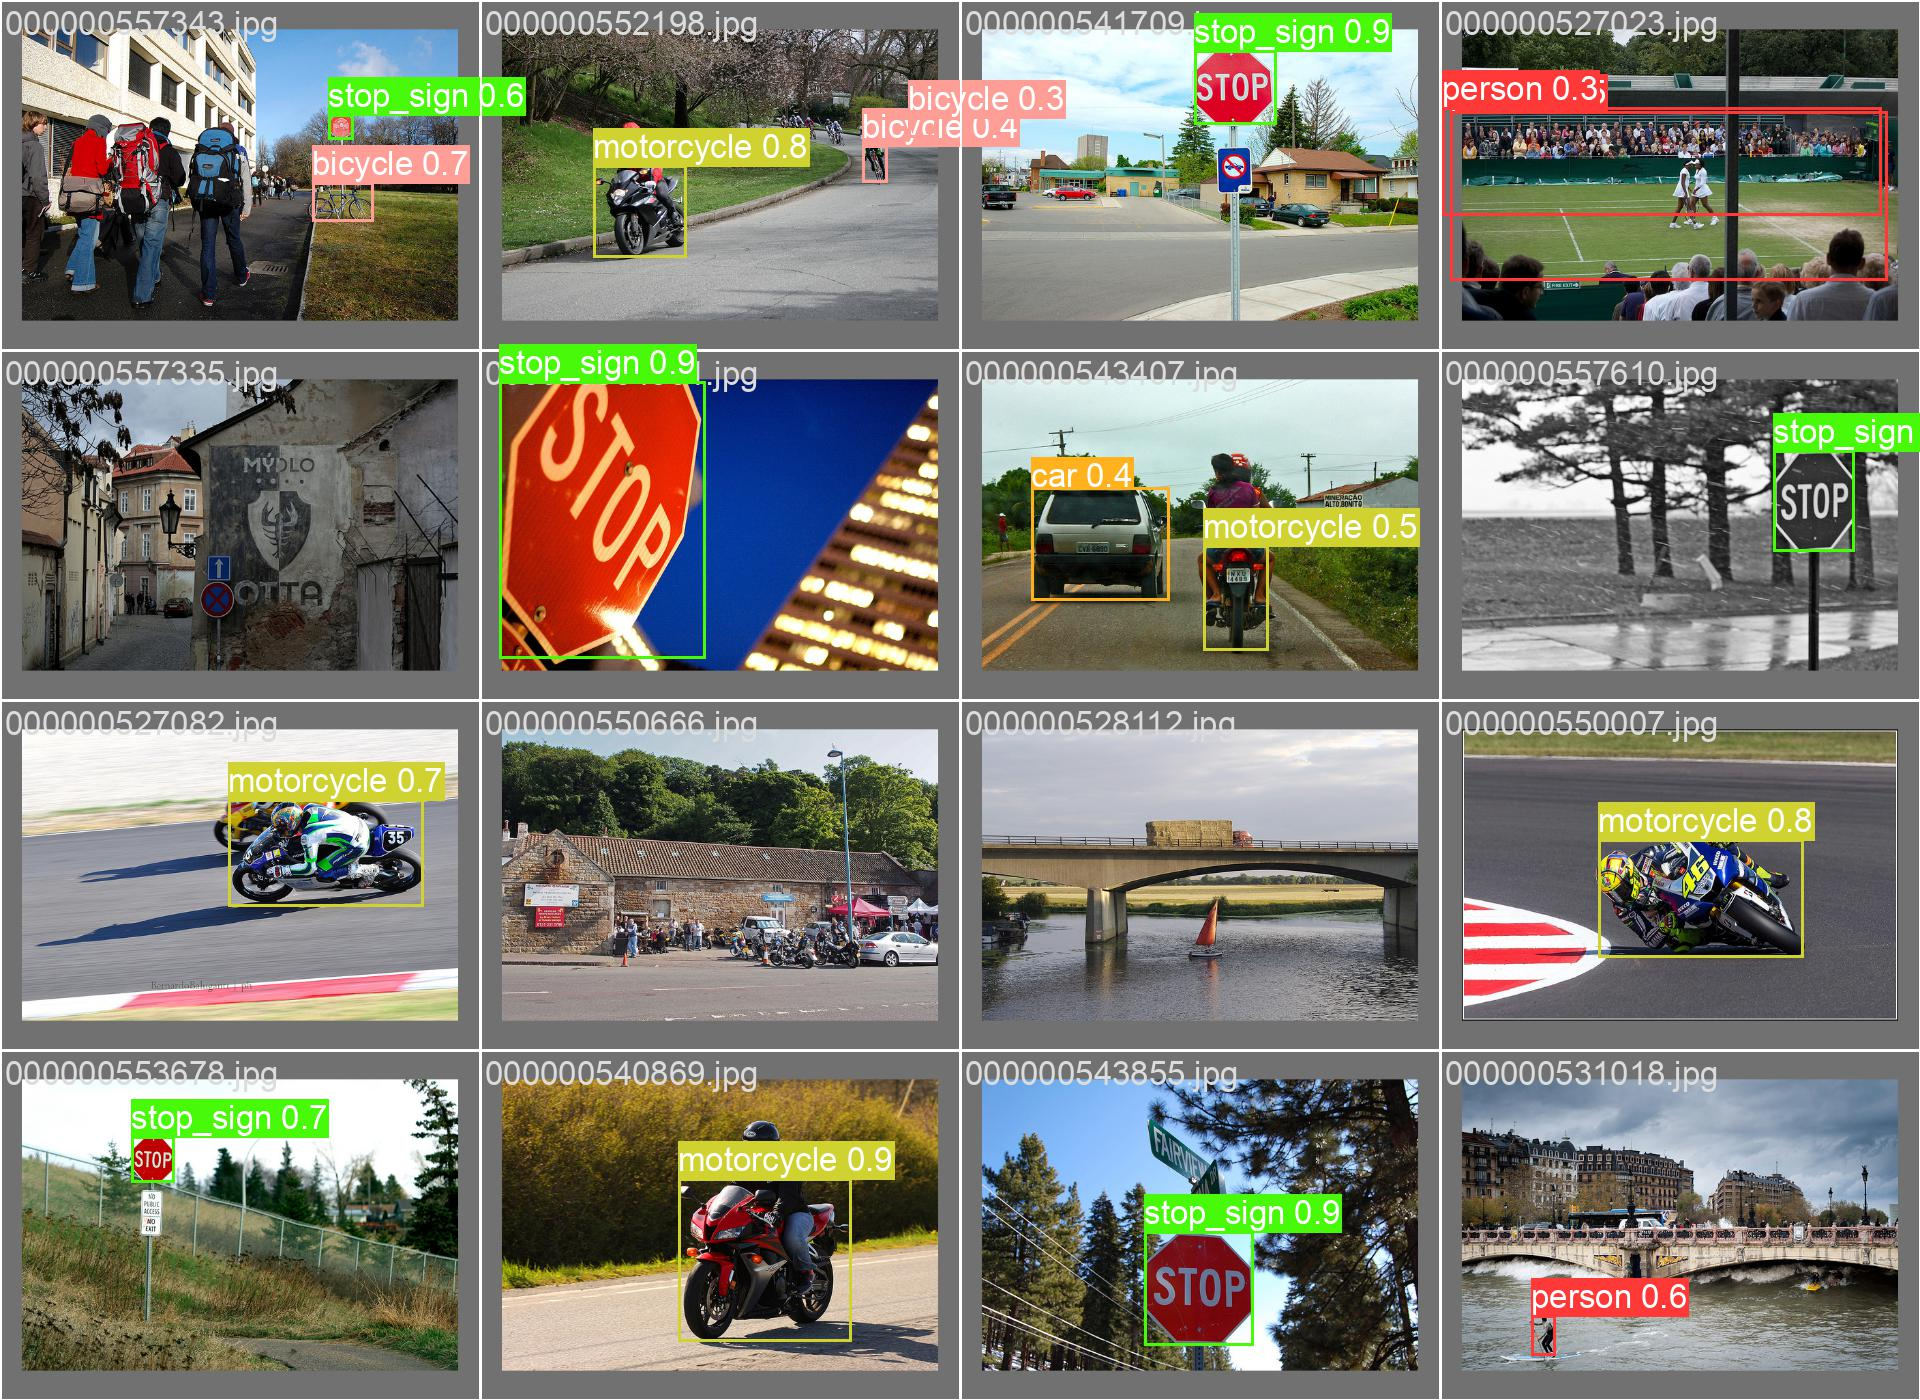

In [43]:
display.Image("..\model_training\\val_batch2_pred.jpg")

In [ ]:
#yolo class to load model in pytorch and function to split video into frames, run yolo model on frame and later stitch those frames to get  with detected bounding boxes as ouput
class YOLO():
    """ CLASS FOR YOLOV5     """

    def __init__(self, model_path):
        #load yolov5 model trained on target tracking dataset
        device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model_path = model_path
        self.model = torch.hub.load('ultralytics/yolov5','custom', model_path).to(device) 
 


    def detect_video(self, video_path, save_video = True):
            
        frame_num = 0
        video = cv2.VideoCapture(video_path)

        out = {}
        frames_list =[]
        while True:
            ret, frame = video.read()
            
            

            if not ret:
                 break


            results = self.model(frame)

    
            results = results.pandas().xyxy[0].to_json(orient="records")
            results = json.loads(results )
    

            print("Frame : ", frame_num)
            print(results)
            print('---------------------')

            if len(results) > 0:
                for i in results:

                    #get coordinates and add them to json dict and draw rectangle on frame
                    xmin = int(round(int(i["xmin"]),0))
                    xmax = int(round(int(i["xmax"]),0))
                    ymin = int(round(int(i["ymin"]),0))
                    ymax = int(round(int(i["ymax"]),0))
                    cv2.rectangle(frame, (xmin, ymin),(xmax, ymax), (0, 255, 0), 3)
                    cv2.putText(frame, i['name'], (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

            frames_list.append(frame)
            frame_num += 1
            k = cv2.waitKey(30) & 0xff
            if k == 27:
                break


            
            video_name = video_path.split('/')[-1].split('.mp4')[0]
            if save_video:
            
                frames_shape = np.array(frames_list)
            

                out = cv2.VideoWriter(video_name + "_det.mp4", cv2.VideoWriter_fourcc(*'DIVX'), 30, (frames_shape.shape[2], frames_shape.shape[1]))

            for frame in frames_list:
                
                out.write(frame)

            out.release()

    


        video.release()
        cv2.destroyAllWindows()

    


In [ ]:
#load model
yolo_model = YOLO("trained_weights.pt") #path for yolo parameters
yolo_model.detect_video("t.mp4") #path for video; gives video and json as output